<a href="https://colab.research.google.com/github/swishswish123/endosim_demo/blob/main/notebooks/pointer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/swishswish123/endosim_demo.git


In [ ]:
!pip install scikit-surgeryvtk

# Tracked Pointer

The current state of the art uses a tracked pointer, registered to a pre-operative MR scan. This notebook explores what the expected level of accuracy might be.

In [ ]:
import copy
import numpy as np
import cv2
import random
from scipy.spatial.transform import Rotation as spr
from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu
from IPython.display import Image



## Utility functions and imports



In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

added /Users/aure/Documents/i4health/project/endoSim/endosim/notebooks to sys


In [ ]:

from endosim_demo.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist



## System layout

The following diagram shows the layout of the navigation system.

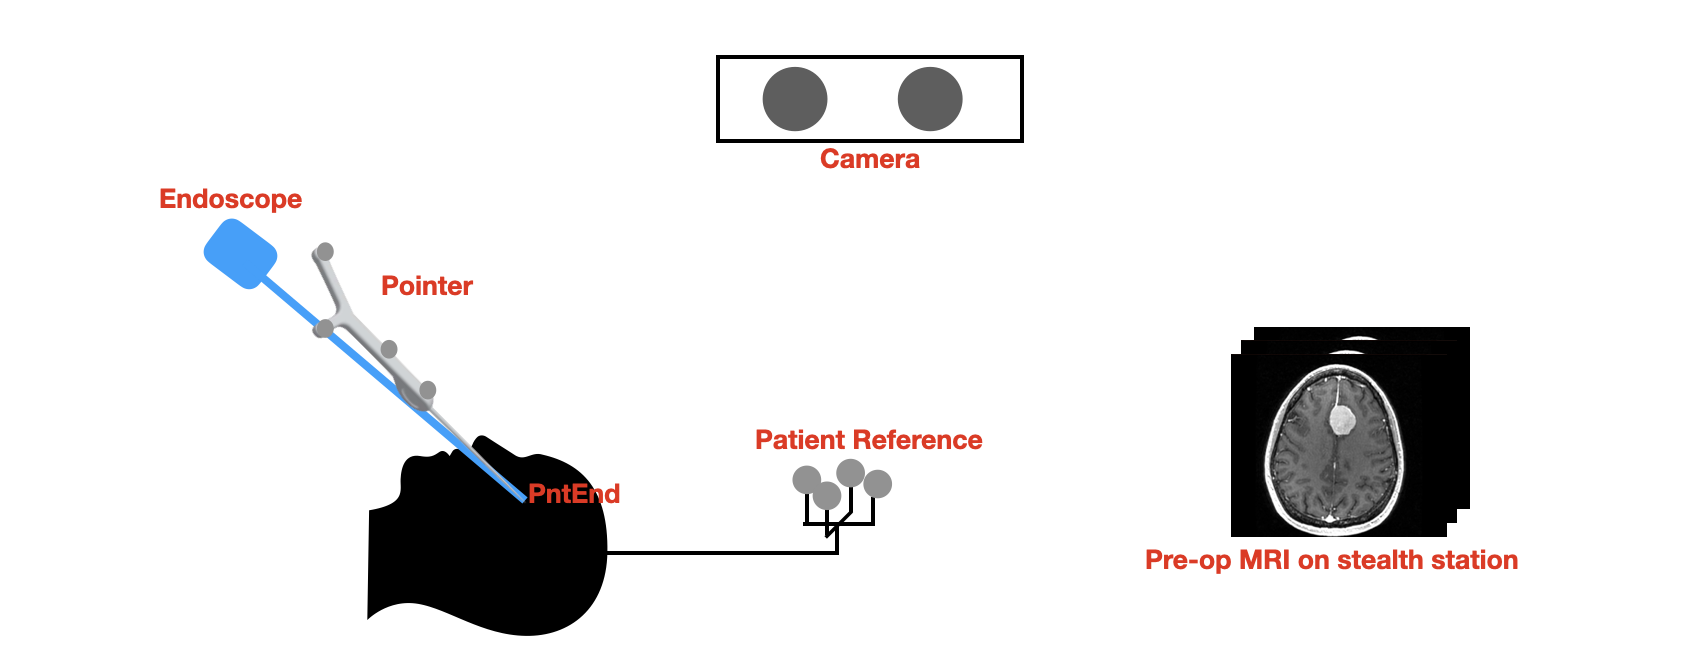

In [ ]:
Image(filename="./endosim_demo/images/pointer_setup.png")

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display the pointer in image coordinates as we can see in the image below:

![pointer on MRI](https://github.com/swishswish123/endosim_demo/blob/main/notebooks/endosim_demo/images/MRI_pointer.png?raw=1)

The goal is therefore turning the pointer's coordinates to MRI coordinates.

X<sub>MRI</sub> = T X<sub>PntEnd</sub>

where T is composed of the following transformations:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>endP</sub>
    
In the following sections we will go step by step on how to go from each of these transforms

Here is an visual representation of the pointer setup with all the transforms:

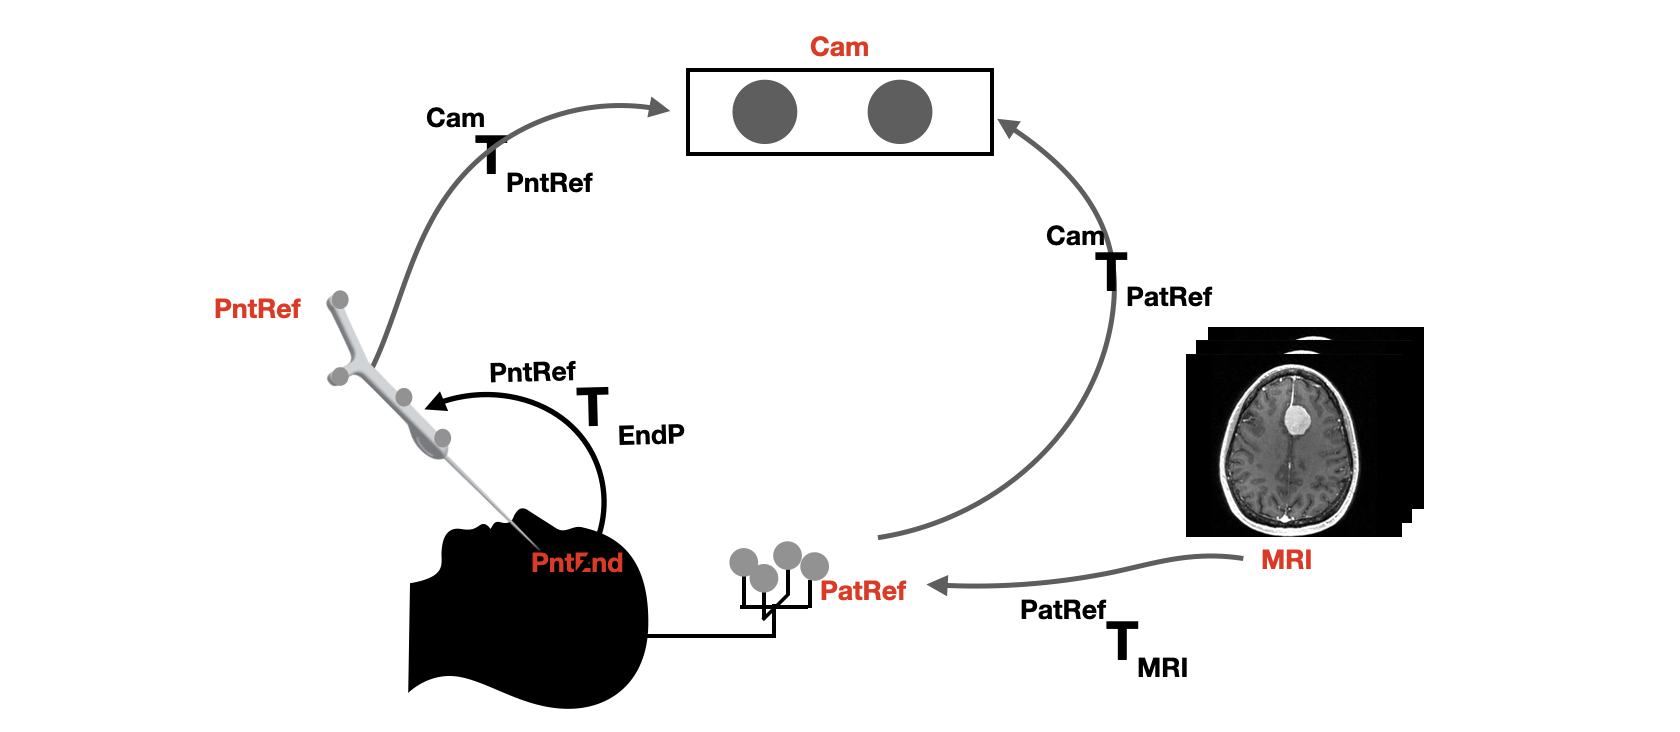

In [ ]:
Image(filename="./endosim_demo/images/pointer_setup_transforms.png")

## Assumptions / setup

1. tumour, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the tumour but aligned in the X direction

3. pointer is touching the tumour, so the pointer and tumour have the same coordinates

4. Length of pointer is known

5. Angle of pointer is known

Below are visual representations of the sagittal and transverse views with all assumptions

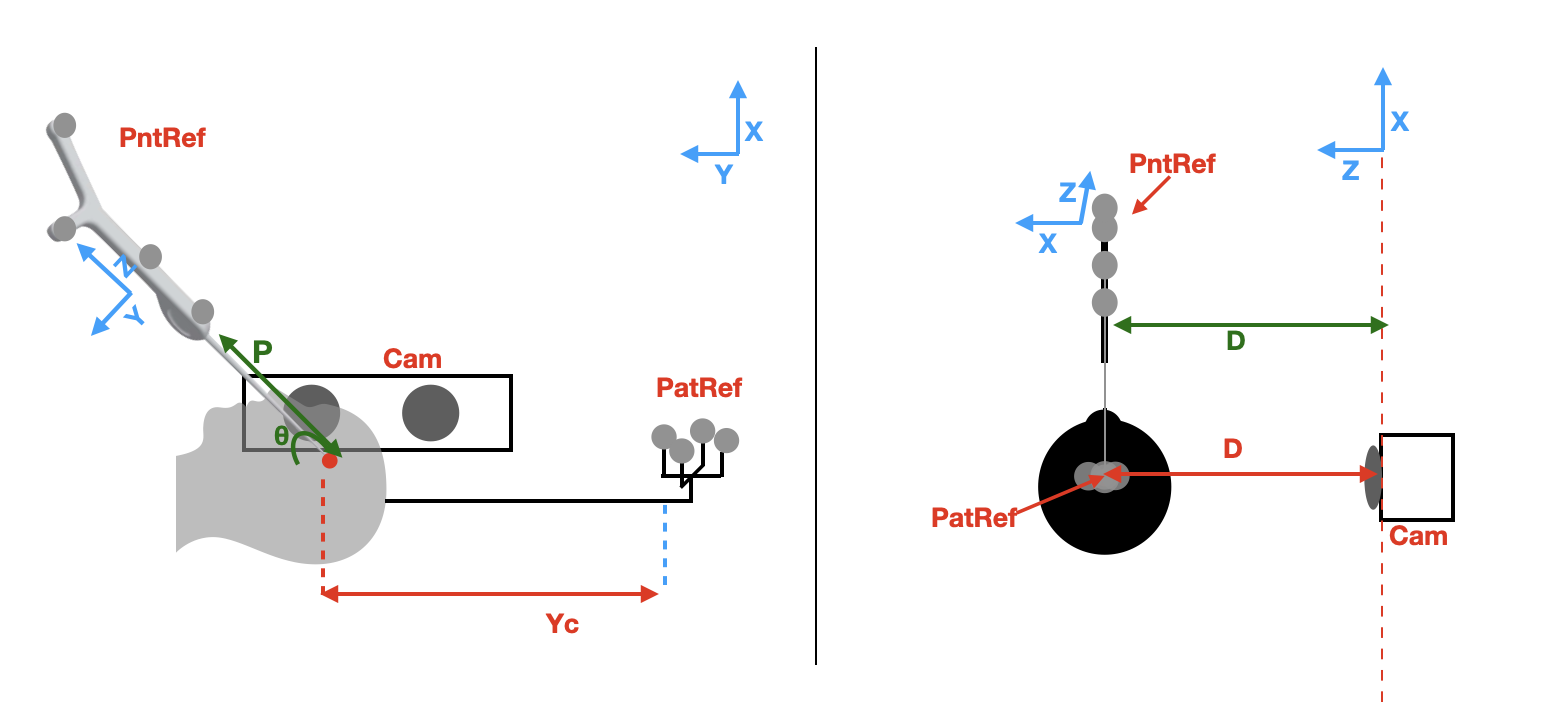

In [ ]:
Image(filename="endosim_demo/images/pointer_setup_assumptions.png")

## Configurable parameters

In [ ]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc - distances from tumour to patient reference
tumour_patref_y = 50

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
typical_tracking_sigma = 0.25

# For Model 2 and 3, using an endoscope, this determines the distance of a target of interest from the endoscope.
working_distance = 50

# For Model 2 and 3, the length of the endoscope.
length_of_endoscope = 300

# for simulation reproducibility
number_samples = 10


## Creating the reference data for the pointer, in pointer coordinates.

Here is an image of the pointer with its reference:

![pointer image](https://github.com/swishswish123/endosim_demo/blob/main/notebooks/endosim_demo/images/pointer_image.png?raw=1)
![pointer image](https://github.com/swishswish123/endosim_demo/blob/main/notebooks/endosim_demo/images/pointer_geometry.png?raw=1)

In our case, let us assume we already know what the length of the pointer is.

In [ ]:
print(f'pointer length is: {pointer_length}mm' )

pointer length is: 100mm


Creating reference points of pointer:

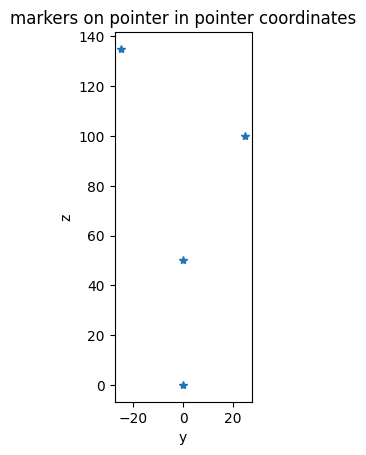

[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]


In [ ]:
pnt_ref = create_pnt_ref()

# Plotting original points, to check it looks ok.
plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

print(pnt_ref)

converting reference points to coordinate system where the origin is at the end of the pointer instead of at marker A.

Original pointer, as per datasheet:
[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]
offset_pointer_transform=
[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
pnt_ref_transformed=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]]
pnt_ref_with_tip=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]


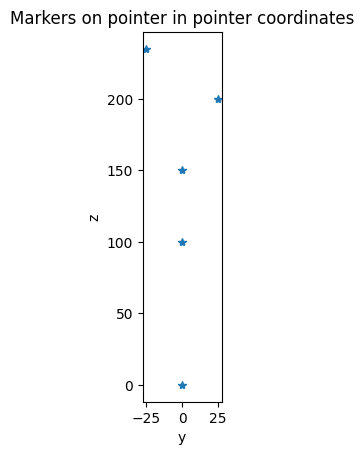

In [ ]:
# Here we offset the points by the length of the pointer.
offset_pointer_transform = get_ref_T_tip(pointer_length, 'z') # create transform of all points depending on pointer's length
pnt_ref_transformed = multiply_points_by_matrix(offset_pointer_transform, pnt_ref, do_transpose=True) # transform all pointer points by this reference
pnt_ref_with_tip = np.concatenate((pnt_ref_transformed, [[0, 0, 0, 1]]), axis=0) # adding tip to points

# displaying results
print("Original pointer, as per datasheet:\n" + str(pnt_ref))
print("offset_pointer_transform=\n" + str(offset_pointer_transform))
print("pnt_ref_transformed=\n" + str(pnt_ref_transformed))
print("pnt_ref_with_tip=\n" + str(pnt_ref_with_tip))

plt.figure()
plt.plot(pnt_ref_with_tip[:,1],pnt_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Creating the reference data for the pointer in camera coordinates

Pointer in camera/tracker space:
[[  0.   0.   0.   1.]
 [ 50.   0.   0.   1.]
 [100.  25.   0.   1.]
 [135. -25.   0.   1.]]
offset_pointer_transform_cam=
[[  1.   0.   0. 100.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_transformed=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]]
pnt_ref_in_camera_space_with_tip=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_at_patient=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]


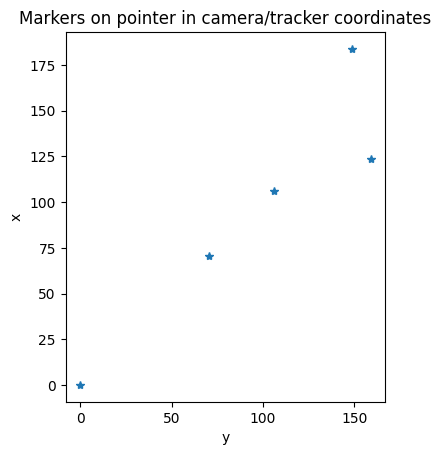

In [ ]:
# pointer reference in camera coordinate system
pnt_ref_in_camera_space = create_pnt_ref_in_camera_space()

# once again creating offset to all the points to move origin to the pointer's tip
offset_pointer_transform_cam = get_ref_T_tip(pointer_length, 'x')
pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(offset_pointer_transform_cam, pnt_ref_in_camera_space, do_transpose=True)
pnt_ref_in_camera_space_with_tip = np.concatenate((pnt_ref_in_camera_space_transformed, [[0, 0, 0, 1]]), axis=0)

print("Pointer in camera/tracker space:\n" + str(pnt_ref_in_camera_space))
print("offset_pointer_transform_cam=\n" + str(offset_pointer_transform_cam))
print("pnt_ref_in_camera_space_transformed=\n" + str(pnt_ref_in_camera_space_transformed))
print("pnt_ref_in_camera_space_with_tip=\n" + str(pnt_ref_in_camera_space_with_tip))

# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
pnt_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_away_from_camera @ rotate_about_z, pnt_ref_in_camera_space_with_tip, do_transpose=True)
print("pnt_ref_in_camera_space_at_patient=\n" + str(pnt_ref_in_camera_space_at_patient))

# Plotting result
plt.figure()
plt.plot(pnt_ref_in_camera_space_at_patient[:,1],pnt_ref_in_camera_space_at_patient[:,0], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in camera/tracker coordinates')
plt.xlabel('y')
plt.ylabel('x')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Computing the Tracking transformation, Cam_T_PntRef.

For sanity checking, we should now be able to register the PntRef model (moving) to Cam (fixed) transform.

In [ ]:
Cam_T_PntRef_r, Cam_T_PntRef_t, Cam_T_PntRef_FRE = pro.orthogonal_procrustes(pnt_ref_in_camera_space_at_patient[:,0:3], pnt_ref_with_tip[:,0:3])
print("Cam_T_PntRef_r=\n" + str(Cam_T_PntRef_r))
print("Cam_T_PntRef_t=\n" + str(Cam_T_PntRef_t))
print("Cam_T_PntRef_FRE=\n" + str(Cam_T_PntRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a rotation and a translation.
Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
print("Cam_T_PntRef=\n" + str(Cam_T_PntRef))


Cam_T_PntRef_r=
[[ 1.45587087e-15 -7.07106781e-01  7.07106781e-01]
 [-1.53604389e-15  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00]]
Cam_T_PntRef_t=
[[2.84217094e-14]
 [1.42108547e-14]
 [1.00000000e+03]]
Cam_T_PntRef_FRE=
2.2914314707516468e-14
Cam_T_PntRef=
[[ 1.45587087e-15 -7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.53604389e-15  7.07106781e-01  7.07106781e-01  1.42108547e-14]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Creating reference data for the the Patient Reference

![real patient reference](https://github.com/swishswish123/endosim_demo/blob/main/notebooks/endosim_demo/images/real_pat_ref.png?raw=1)


![patient reference coordinates](https://github.com/swishswish123/endosim_demo/blob/main/notebooks/endosim_demo/images/pointer_patref_marker.png?raw=1)

In [ ]:
# Defining reference coordibates in ref coords (from datasheet)
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45
    
# Encoding the reference marker points into a numpy matrix
pat_ref = create_pat_ref()
print(pat_ref)

[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]


## Creating the reference data for the patient reference in camera space.

From the above assumptions, we remember that:

- we assume the patient reference centre is at the same level as the tumour and so the x coordinates are the same
- the distance in y direction between tumour and reference is known


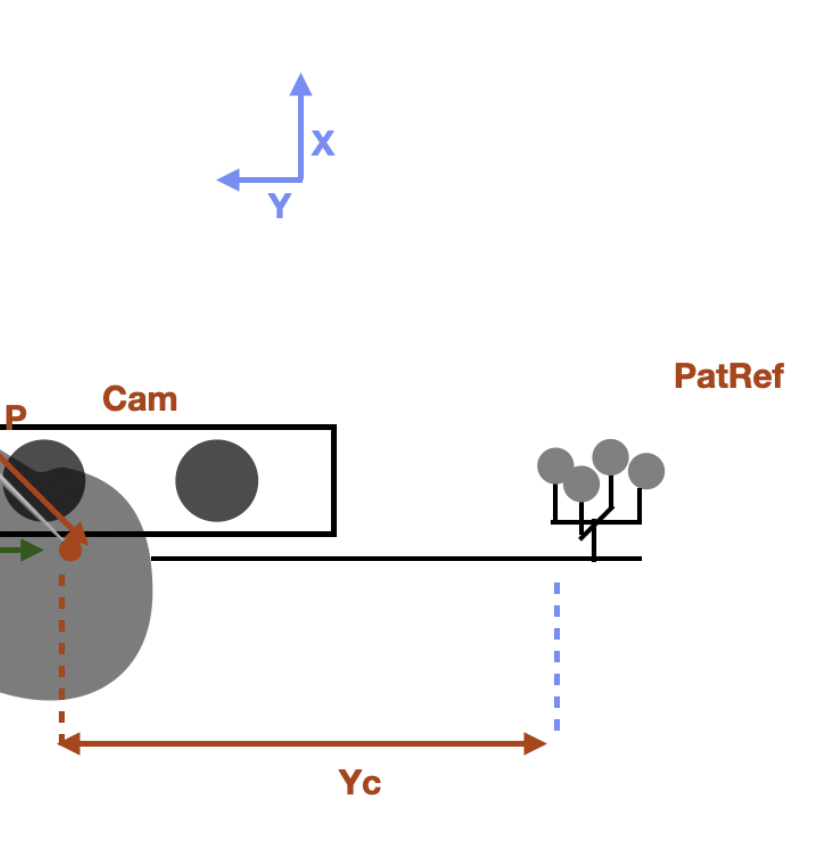

In [ ]:
Image(filename="endosim_demo/images/pat_ref_assumptions.png")


The patient reference model coordinates are in the YZ plane. In camera space, the X direction is vertical, the Z direction goes from the camera to the patient. So, in camera space, let's place these points in the ZY plane. Therefore, we need to swap the Y, Z coordinates, then translate to the patient, followed by a translation along the negative Y axis to match the picture above. 

[[  0.     0.     0.     0.  ]
 [  0.    41.02  28.59   0.  ]
 [  0.    88.     0.     0.  ]
 [  0.    40.45 -44.32   0.  ]]
Patient ref, in model coordinates=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref, in camera coordinates=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


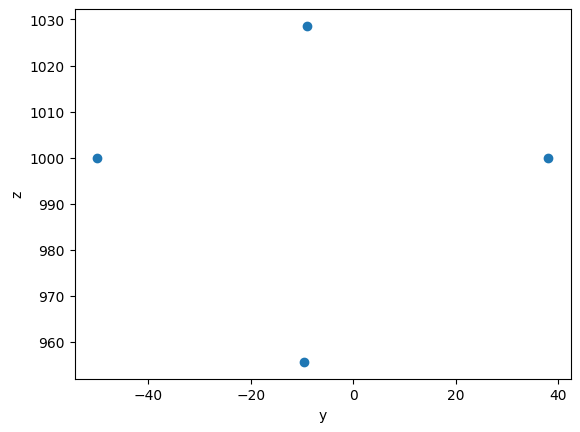

In [ ]:
# Encoding the reference marker points into a numpy matrix, in camera space.
pat_ref_in_camera_space = create_pat_ref_in_camera_space()

# Now put it in the right place.
translate_along_negative_y = create_transform([0, -tumour_patref_y, 0, 0, 0, 0])
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_along_negative_y @ translate_away_from_camera, pat_ref_in_camera_space, do_transpose=True)

print("Patient ref, in model coordinates=\n" + str(pat_ref))
print("Patient ref, in camera coordinates=\n" + str(pat_ref_in_camera_space_at_patient))

plt.figure()
plt.scatter(pat_ref_in_camera_space_at_patient[:,1], pat_ref_in_camera_space_at_patient[:,2])
plt.xlabel('y')
plt.ylabel('z')
plt.show()

## Computing the Tracking transformation Cam_T_PatRef

In [ ]:

# As above, compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, Cam_T_PatRef_FRE = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a translation, with no rotation.
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))


Cam_T_PatRef_r=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.23977310e-16  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -9.10512328e-17]]
Cam_T_PatRef_t=
[[   0.]
 [ -50.]
 [1000.]]
Cam_T_PatRef_FRE=
9.39959687352353e-15
Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.23977310e-16  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.10512328e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## MRI_T_PatRef coordinates

In order to convert CT coordinates to patient reference coordinates, we typically would take the pointer and move it over the surface of the patient's head. The software would collect coordinates of the tip of the pointer, and transform them to the patient reference coordinate system. We then use an ICP algorithm to match the two surfaces of the points on the face. This results in PatRef_T_MRI as shown above.

For the purpose of this simulation, we can place the pre-operative MRI and the patient's head scan at an offset to the patient reference, which has already been placed near the patient's head.

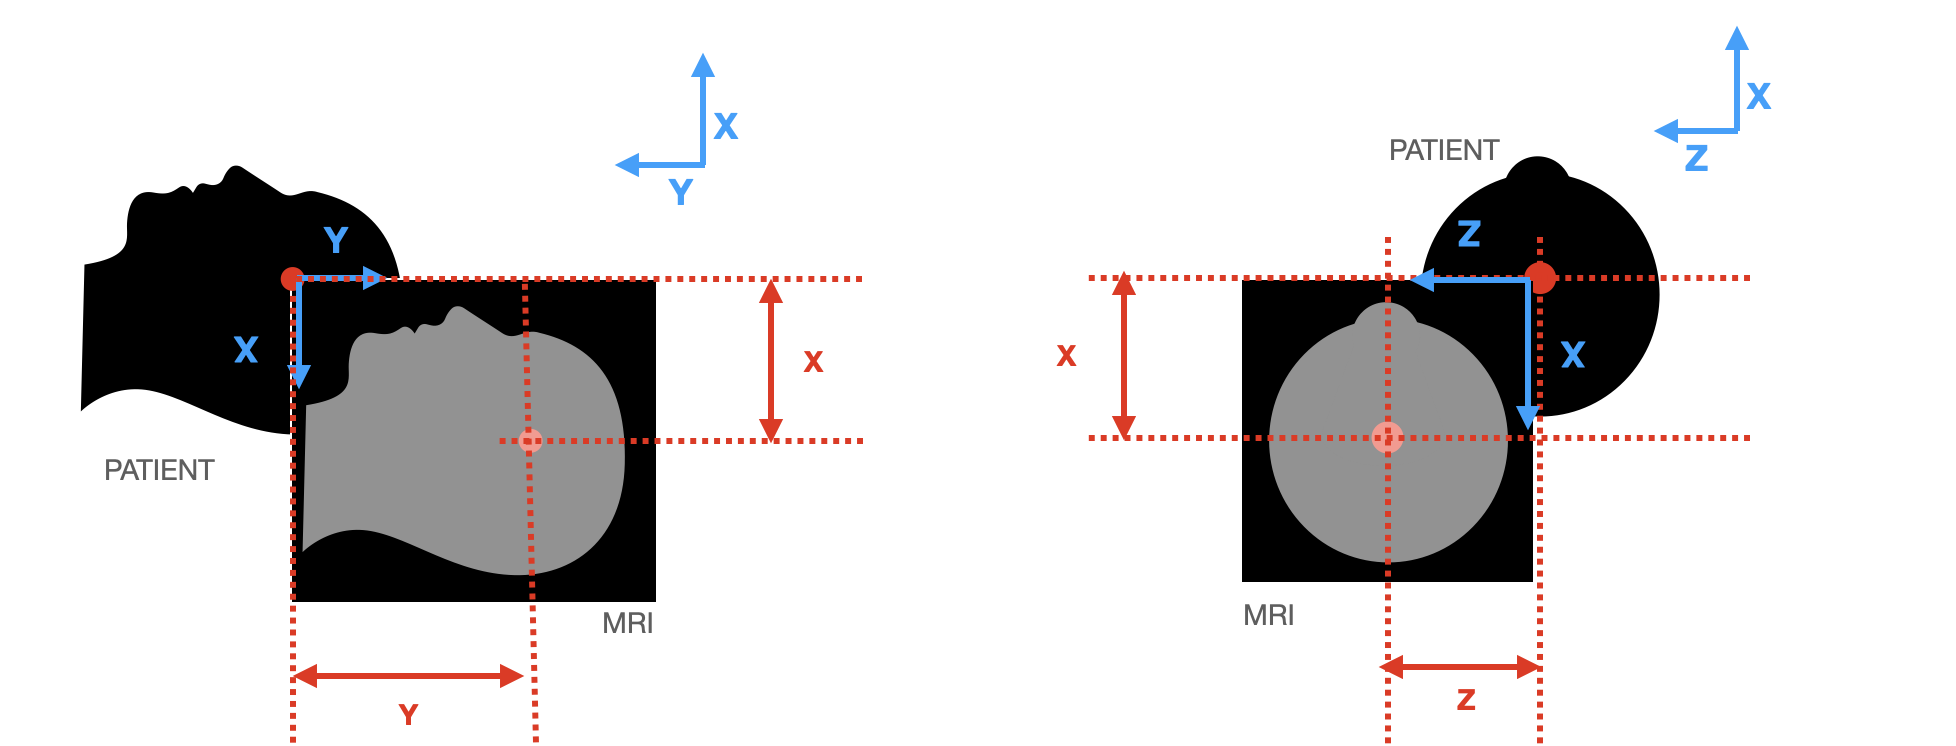

In [ ]:
Image(filename="endosim_demo/images/3D_to_cam.png")

The placements shown are based on average head dimensions:

In [ ]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("Cam_T_PntRef=\n" + str(PatRef_T_MRI))

Cam_T_PntRef=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


# Summary of Reference data.

Give this setup:

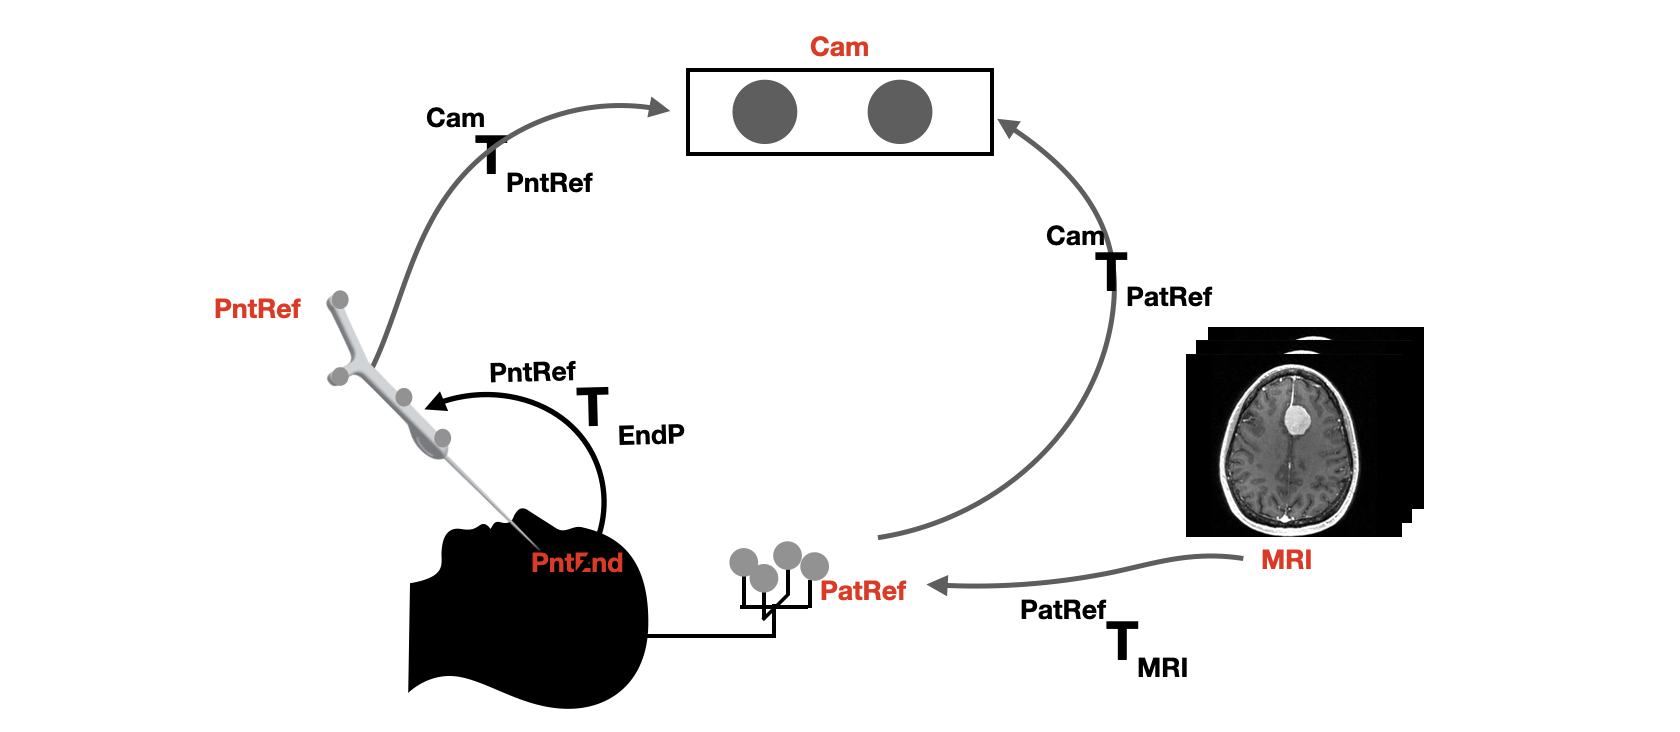

In [ ]:
Image(filename="endosim_demo/images/pointer_setup_transforms.png")

we have now computed the following transformations:

In [ ]:
print("Summary: pointer tip to pointer ref PntRef_T_EndP =\n" + str(offset_pointer_transform)) 
print("Summary: pointer ref to camera Cam_T_PntRef=\n" + str(Cam_T_PntRef)) 
print("Summary: patient ref to camera Cam_T_PatRef=\n" + str(Cam_T_PatRef))
print("Summary: mri to patient ref PatRef_T_MRI=\n" + str(PatRef_T_MRI))

Summary: pointer tip to pointer ref PntRef_T_EndP =
[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
Summary: pointer ref to camera Cam_T_PntRef=
[[ 1.45587087e-15 -7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.53604389e-15  7.07106781e-01  7.07106781e-01  1.42108547e-14]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: patient ref to camera Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.23977310e-16  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.10512328e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: mri to patient ref PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


and we constructed the pointer so that the origin is at the tip, then computed Cam_T_PntRef based on this. 

So, in the above diagram, PntRef_T_EndP is effectively the identity transformation.

In addition, we can place the tumour at the location given by the pointer tip:


In [ ]:
origin = [0, 0, 0]

# Tumor in camera space
#tumour_in_camera_space = multiply_point_by_matrix(Cam_T_PntRef, origin)
tumour_in_camera_space = np.array([ [0],[0],[distance_from_cam],[1] ])
print("Tumour location in camera space=\n" + str(tumour_in_camera_space))

# Tumor in MRI space
tumour_in_mri_space = pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, origin)
print("Tumour location in MRI space=\n" + str(tumour_in_mri_space))

# Transforming tumor in camera space to MRI space to check it is the same   
transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) 
tumour_MRI_from_Cam = multiply_point_by_matrix(transform, tumour_in_camera_space)
print('Tumour location in MRI space after transforming camera space one')
print(tumour_MRI_from_Cam)

Tumour location in camera space=
[[   0]
 [   0]
 [1000]
 [   1]]
Tumour location in MRI space=
[[100.]
 [130.]
 [130.]
 [  1.]]
Tumour location in MRI space after transforming camera space one
[[100.]
 [130.]
 [130.]
 [  1.]]


And we have the following reference data from above:

In [ ]:
print("Pointer model=\n" + str(pnt_ref_with_tip))
print("Pointer model in camera space=\n" + str(pnt_ref_in_camera_space_at_patient))
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))


Pointer model=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]
Pointer model in camera space=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]
Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref model in camera space=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


which are the 4 sets of points that we computed tracking transformations from, using orthogonal procrustes.

# Summary of steps

#### PntRef_T_PntEnd

pointer reference

In [ ]:
pnt_ref

array([[  0.,   0.,   0.,   1.],
       [  0.,   0.,  50.,   1.],
       [  0.,  25., 100.,   1.],
       [  0., -25., 135.,   1.]])

PntRef_T_PntEnd

We transform the pointer reference from reference coordinates to pointer's end coordinate system, where the origin is at the pointer's tip


In [ ]:
PntRef_T_PntEnd = get_ref_T_tip(pointer_length, 'z')
# pointer reference in endoscopic coordinates
pnt_ref_transformed = multiply_points_by_matrix(PntRef_T_PntEnd, pnt_ref, do_transpose=True) # transform all pointer points by this transform
print('pointer reference after being translated by pointer length (PntRef_T_PntEnd)')
print(pnt_ref_transformed)

pointer reference after being translated by pointer length (PntRef_T_PntEnd)
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]]


#### Cam_T_PntRef

We now create the reference but in camera coordinates

Original reference (as the scale is the same)

In [ ]:
pnt_ref_in_camera_space

array([[  0.,   0.,   0.,   1.],
       [ 50.,   0.,   0.,   1.],
       [100.,  25.,   0.,   1.],
       [135., -25.,   0.,   1.]])

We translate it so that the origin is at the pointer's tip

In [ ]:
offset_pointer_transform_cam = get_ref_T_tip(pointer_length, 'x')
pnt_ref_in_camera_space_offset = multiply_points_by_matrix(offset_pointer_transform_cam, pnt_ref_in_camera_space, do_transpose=True)
print('pointer reference after being translated by pointer length (camera)')
print(pnt_ref_in_camera_space_offset)


pointer reference after being translated by pointer length (camera)
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]]


We then want to rotate it to the angle specified and translate it away from the camera at the distance the patient is from the camera


In [ ]:
# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])

# composing the 2 transformations
rotate_translate = translate_away_from_camera @ rotate_about_z 

# transforming reference coordinates by these transformations
pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(rotate_translate, pnt_ref_in_camera_space_offset, do_transpose=True)

print('pnt_ref_in_camera_space_transformed is pointer reference in camera coordinates (after being put in position)')
print(pnt_ref_in_camera_space_transformed)


pnt_ref_in_camera_space_transformed is pointer reference in camera coordinates (after being put in position)
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]]


Now we have the pointer's reference both in camera coordinates and in pointer coordinates so we can get the transformation Cam_T_PntRef by matching the two

In [ ]:
print('pointer reference in reference coords: ')
print(pnt_ref_transformed[:,0:3])

print('pointer reference in camera coords: ')
print(pnt_ref_in_camera_space_transformed[:,0:3])


pointer reference in reference coords: 
[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]
pointer reference in camera coords: 
[[  70.71067812   70.71067812 1000.        ]
 [ 106.06601718  106.06601718 1000.        ]
 [ 123.74368671  159.09902577 1000.        ]
 [ 183.84776311  148.49242405 1000.        ]]


In [ ]:
Cam_T_PntRef_r, Cam_T_PntRef_t, _ = pro.orthogonal_procrustes(pnt_ref_in_camera_space_transformed[:,0:3], pnt_ref_transformed[:,0:3])

# Now we construct the 4x4 tracking transformation. 
Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
print("Cam_T_PntRef=\n" + str(Cam_T_PntRef))

Cam_T_PntRef=
[[ 8.31476113e-16 -7.07106781e-01  7.07106781e-01 -1.42108547e-14]
 [-1.00518614e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -1.29728588e-15 -1.91457875e-18  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### PatRef_T_Cam

We have the original patient reference in patient reference coordinates

In [ ]:
pat_ref

array([[  0.  ,   0.  ,   0.  ,   1.  ],
       [  0.  ,  28.59,  41.02,   1.  ],
       [  0.  ,   0.  ,  88.  ,   1.  ],
       [  0.  , -44.32,  40.45,   1.  ]])

Similarly to the pointer reference, we want to get it in camera coordinates so we can get the transform between the two


We start with the reference at the same scale but swapping the necessary axes

In [ ]:
pat_ref_in_camera_space

array([[  0.  ,   0.  ,   0.  ,   1.  ],
       [  0.  ,  41.02,  28.59,   1.  ],
       [  0.  ,  88.  ,   0.  ,   1.  ],
       [  0.  ,  40.45, -44.32,   1.  ]])

And we then move the reference so that it is at the correct position- both away from the camera and relative to the patient

In [ ]:
# translation to correct place relative to patient
translate_along_negative_y = create_transform([0, -tumour_patref_y, 0, 0, 0, 0])
# composing transformation of translation relative to patient and translation away from the camera (which was calculated previously)
positioning_pat_ref_transform = translate_along_negative_y @ translate_away_from_camera

# moving all patient reference points by the calculated translation
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(positioning_pat_ref_transform, pat_ref_in_camera_space, do_transpose=True)


So now we have the patient reference both in reference coordinates and in camera coordinates.

In [ ]:
print("Patient ref, in model coordinates=\n" + str(pat_ref))
print("Patient ref, in camera coordinates=\n" + str(pat_ref_in_camera_space_at_patient))

Patient ref, in model coordinates=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref, in camera coordinates=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


Therefore we can get the transformation between the two by matching the points

In [ ]:
# First we compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, _ = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])

# And then construct the corresponding 4x4 tracking transformation. 
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))


Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.23977310e-16  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.10512328e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### MRI_T_PatRef

Finally we have the transformation between the patient reference and the MRI

In [ ]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))

PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


#### Trying these transformations out

In [ ]:
print('PntRef_T_PntEnd=\n', PntRef_T_PntEnd)
print('Cam_T_PntRef=\n', Cam_T_PntRef)
print('Cam_T_PatRef=\n', Cam_T_PatRef)
print('PatRef_T_MRI=\n', PatRef_T_MRI)


PntRef_T_PntEnd=
 [[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
Cam_T_PntRef=
 [[ 8.31476113e-16 -7.07106781e-01  7.07106781e-01 -1.42108547e-14]
 [-1.00518614e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -1.29728588e-15 -1.91457875e-18  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Cam_T_PatRef=
 [[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.23977310e-16  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.10512328e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
PatRef_T_MRI=
 [[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


# Simulation 1: Effect of tracking noise on pointer tip accuracy.

Here we add random noise to the location of the tracking markers (pointer and patient ref) and see how far tip position moves relative to the tumour.

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.05
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

In [ ]:
x_values = []
y_values = []
for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):

        # adding noise to pointer reference and patient reference markers
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_at_patient[0:4,0:3], sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
        
        # getting transform from noisy pointer reference to camera
        R, t, FRE = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_with_tip[0:4, 0:3])
        tmp_pointer_to_cam = mu.construct_rigid_transformation(R, t)
        # getting transform from noisy pointer reference to camera
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        # transforming from pointer tip to MRI space with noisy transforms
        pointer_tip_in_mri_space = pointer_to_mri(tmp_pointer_to_cam, tmp_reference_to_cam, PatRef_T_MRI, origin)
        
        # euclid_dist is x^2+y^2+x^2
        euclid_dist = calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space)
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.25:
        print(f'rms for sigma of 0.25 is {rms}')
        rms_25_tracking = rms
    if sigma == 0.12:
        print(f'rms for sigma of 0.12 is {rms}')
        rms_12_tracking = rms
    if sigma == 0.15:
        print(f'rms for sigma of 0.15 is {rms}')
        rms_15_tracking = rms
    
    x_values.append(sigma)
    y_values.append(rms)
    
      
        

rms for sigma of 0.12 is [0.31856281]
rms for sigma of 0.15 is [0.39764605]
rms for sigma of 0.25 is [0.66275002]


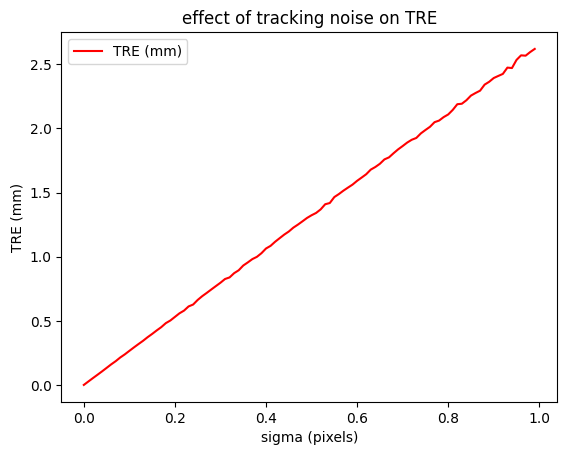

In [ ]:
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('TRE (mm)')
plt.title('effect of tracking noise on TRE')
plt.show()

# Simulation 2: Effect of pointer length

Here we change the length of the pointer to see what the corresponding target registration error (TRE) is with tracking noise.

The way this code is written, the pointer length is used to generate the test data. Also vendors provide a specific pointer. So, in practice we wont be responsible for designing a new pointer.

To study the effect of pointer length, just vary the parameter 'pointer_length' above, and re-run the simulation.

In [ ]:
def get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, pointer_length = 100,pointer_angle = 45, distance_from_cam = 1000, tumour_patref_y = 50  , x_t = 100, y_t = 130, z_t = 80, sigma=False):
    """get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, pointer_length = 100,pointer_angle = 45, distance_from_cam = 1000, tumour_patref_y = 50  , x_t = 100, y_t = 130, z_t = 80, sigma=False)

    Function that generates all tracking transforms to match from pointer's end in pointer end coordinates to MRI coordinates.

    :param pnt_ref: Numpy ndarray, 4x4, pointer reference- first dimension is the markers (there are 4 markers) and second is the dimension- x,y,z,1
    :param pnt_ref_in_camera_space: Numpy ndarray, 4x4, same as pnt_ref but in camera coordinates
    :param pat_ref: 4x4, patient reference - dimensions representing same as pat_ref
    :param pat_ref_in_camera_space: Numpy ndarray, 4x4, same as pat_ref but in camera coordinates
    :param pointer_length = 100: int, length of pointer (from tip to the first marker)
    :param pointer_angle = 45: int, angle at which the pointer is oriented relative to the camera
    :param distance_from_cam = 1000: int, z distance from the camera to the patient (more specifically to the location where the tumour is located)
    :param tumour_patref_y = 50: distance from tumour to patient reference
    :param x_t = 100: head length (about 200mm)
    :param y_t = 130: menton to top of head (about 250mm)
    :param z_t = 80: head bredth (about 150mm)
    :param sigma=False: how much gaussian noise to introduce to the patient and pointer reference markers

    """
    
    ############ Pointer end to pointer reference
    PntRef_T_PntEnd = get_ref_T_tip(pointer_length, 'z')
    # pointer reference in pointer coordinates
    pnt_ref_transformed = multiply_points_by_matrix(PntRef_T_PntEnd, pnt_ref, do_transpose=True) # transform all pointer points by this transform
    
    ############# Pointer reference to camera
    # pointer reference in camera space 
    offset_pointer_transform_cam = get_ref_T_tip(pointer_length, 'x')
    pnt_ref_in_camera_space_offset = multiply_points_by_matrix(offset_pointer_transform_cam, pnt_ref_in_camera_space, do_transpose=True)
    # transforms to position reference correctly
    rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
    translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
    rotate_translate = translate_away_from_camera @ rotate_about_z  # composing the 2 transformations
    # final camera position
    pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(rotate_translate, pnt_ref_in_camera_space_offset, do_transpose=True)
    
    # ADDING TRACKING NOISE
    if sigma:
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_transformed[0:4,0:3], sigma)
    # and now we get the transformation
    Cam_T_PntRef_r, Cam_T_PntRef_t, _ = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_transformed[:,0:3])
    # Now we construct the 4x4 tracking transformation. 
    Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
    
    
    ############# Camera to patient reference
    # translation to correct place relative to patient
    translate_along_negative_y = create_transform([0, -tumour_patref_y, 0, 0, 0, 0])
    # composing transformation of translation relative to patient and translation away from the camera (which was calculated previously)
    positioning_pat_ref_transform = translate_along_negative_y @ translate_away_from_camera
    # moving all patient reference points by the calculated translation
    pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(positioning_pat_ref_transform, pat_ref_in_camera_space, do_transpose=True)
    if sigma:
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
    # First we compute the tracking transformation.
    Cam_T_PatRef_r, Cam_T_PatRef_t, _ = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4,0:3])
    # And then construct the corresponding 4x4 tracking transformation. 
    Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
    #PatRef_T_Cam = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
    #PatRef_T_Cam = np.linalg.inv(Cam_T_PatRef)                                                                  

    ############# Patient reference to MRI                                                       
    PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
    MRI_T_PatRef = np.linalg.inv(PatRef_T_MRI)      
                                                                  
    return PntRef_T_PntEnd, Cam_T_PntRef, Cam_T_PatRef, MRI_T_PatRef
    

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev and of sigma
* for sigma in [0.12, 0.15, 0.25, 0.5]
    * for pointer_length in 10 to 30, in steps of 5
    *   for iteration in 1 to 1000.
    *     compute transforms with the selected noise
    *     recompute position of pointer tip
    *     measure Euclidean distance in MRI space
    * 
    *   compute RMS error over each iteration
    * produce graph of RMS (TRE) for each value of sigma
```



sigma 0.12
pointer length of 100mm results in noise 0.12  [0.3176935]
pointer length of 150mm results in noise 0.12  [0.39159599]
pointer length of 200mm results in noise 0.12  [0.47040248]
sigma 0.15
pointer length of 100mm results in noise 0.15  [0.39762355]
pointer length of 150mm results in noise 0.15  [0.49110128]
pointer length of 200mm results in noise 0.15  [0.58819692]
sigma 0.25
pointer length of 100mm results in noise 0.25  [0.65837841]
pointer length of 150mm results in noise 0.25  [0.81536202]
pointer length of 200mm results in noise 0.25  [0.97482493]
sigma 0.5
pointer length of 100mm results in noise 0.5  [1.33489102]
pointer length of 150mm results in noise 0.5  [1.65327494]
pointer length of 200mm results in noise 0.5  [1.97785441]


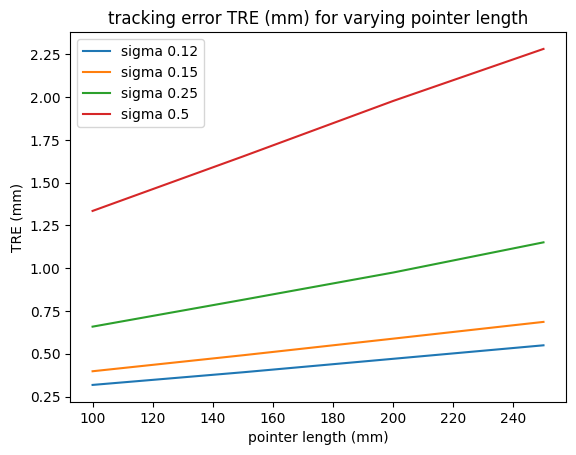

In [ ]:

pointer_lengths_12=[]
pointer_lengths_15=[]
pointer_lengths_25=[]

for sigma in [ 0.12, 0.15, 0.25, 0.5]:
    # for each sigma calculate effect of different pointer lengths   
    x_values = []
    y_values = []
    print(f'sigma {sigma}')

    for pointer_length in range(100, 300, 50):
        rms = 0
        for i in range(number_samples):
            # getting noisy transforms
            PntRef_T_PntEnd, Cam_T_PntRef, PatRef_T_Cam, MRI_T_PatRef = get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, pointer_length = pointer_length, sigma = sigma)
            # transforming pointer tip (tumour location) to MRI space
            pointer_tip_in_mri_space = pointer_to_mri(Cam_T_PntRef, PatRef_T_Cam, PatRef_T_MRI, origin)
            # calculating RMS between noisy and not noisy tumour location
            euclid_dist = calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space)
            rms = rms + euclid_dist
        rms = rms / float(number_samples)
        rms = np.sqrt(rms)
        
        if pointer_length == 100 or pointer_length == 150 or pointer_length == 200:
            
            print(f'pointer length of {pointer_length}mm results in noise {sigma} ', rms)
            if sigma ==0.12:
                pointer_lengths_12.append(rms)
            elif sigma == 0.15:
                pointer_lengths_15.append(rms)
            elif sigma == 0.25:
                pointer_lengths_25.append(rms) 

        x_values.append(pointer_length)
        y_values.append(rms)

    plt.plot(x_values, y_values, label=f'sigma {sigma}')
    plt.legend(loc='upper left')
    plt.xlabel('pointer length (mm)')
    plt.ylabel('TRE (mm)')
    plt.title(f'tracking error TRE (mm) for varying pointer length')

plt.show()


# Simulation 3: Effect of distance from tracker length


### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev and of sigma
* for distance from camera in 1m to 10m, in steps of 1m
*   for iteration in 1 to (number of samples)
*     compute transforms with the selected noise
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```



sigma 0.12: [0.31898814]
sigma 0.15: [0.39783397]
sigma 0.25: [0.6636928]


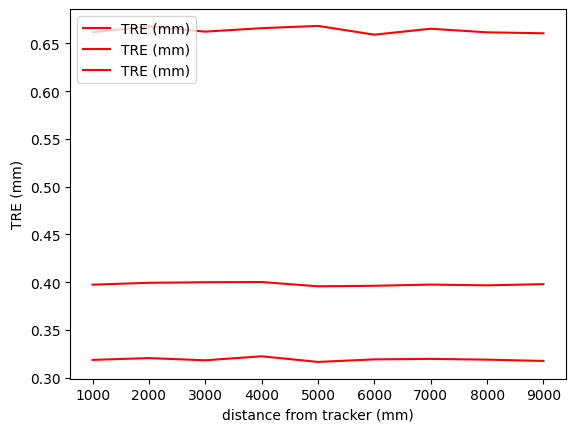

In [ ]:

for sigma in [0.12, 0.15, 0.25]:
    x_values = []
    y_values = []
    for distance_from_cam in range(1000, 10000, 1000): # in mm

        rms = 0
        for i in range(number_samples):
            # getting noisy transforms
            PntRef_T_PntEnd, Cam_T_PntRef, PatRef_T_Cam, MRI_T_PatRef = get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, distance_from_cam = distance_from_cam, sigma=sigma)
            # transforming pointer tip (tumour location) to MRI space
            pointer_tip_in_mri_space = pointer_to_mri(Cam_T_PntRef, PatRef_T_Cam, PatRef_T_MRI, origin)
            # calculating RMS between noisy and not noisy tumour location
            euclid_dist = calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space)
            rms = rms + euclid_dist
            
        rms = rms / float(number_samples)
        rms = np.sqrt(rms)
        x_values.append(distance_from_cam)
        y_values.append(rms)
    
    print(f'sigma {sigma}: {sum(y_values)/len(y_values)}')

    plt.plot(x_values, y_values, 'r', label='TRE (mm)')
    plt.legend(loc='upper left')
    plt.xlabel('distance from tracker (mm)')
    plt.ylabel('TRE (mm)')

plt.show()


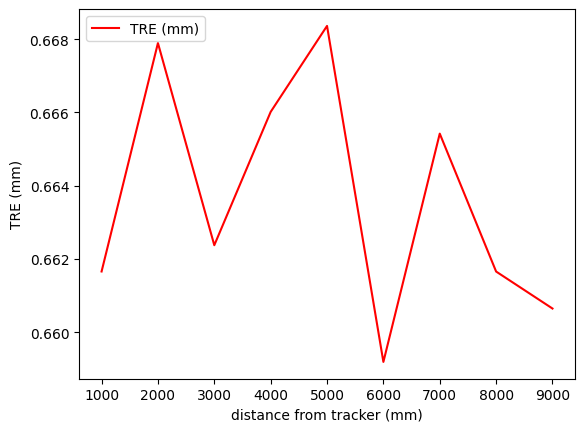

In [ ]:
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('distance from tracker (mm)')
plt.ylabel('TRE (mm)')
plt.show()

We also need to note the NDI specification

![polaris limits](https://github.com/swishswish123/endosim_demo/blob/main/notebooks/endosim_demo/images/polaris_limits.png?raw=1)

# Simulation 4: Effect of misregistration of pre-op data

The total system accuracy will be affected by the PatRef_T_MRI transformation. This is achieved using a point-based-registration (PBR), or an ICP surface-based-registration. However, ultimately, both produce a rigid matrix. If we decompose the PatRef_T_MRI matrix into individual rotations and translations, we can study the effect of registration error, as noise is added to these rotation and translation parameters.

In [ ]:
# These are the baseline parameters for the MRI registration (whether thats PBR or SBR)
PatRef_T_MRI_parameters = extract_rigid_body_parameters(PatRef_T_MRI)
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))


PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]
PatRef_T_MRI_parameters=[0.0, 0.0, 0.0, -100.0, -130.0, -80.0]


```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian (sigma) noise to each tracking marker for pnt ref and pat ref. 
*     add zero mean Gaussian (sigma) noise to each parameter of the PatRef_T_MRI transform
*     recompute transforms.
*     recompute position of pointer tip using noisy transforms
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

euclidean distance for sigma of 0.12 is [0.93185268]
euclidean distance for sigma of 0.15 is [1.05195266]
euclidean distance for sigma of 0.25 is [1.53146262]


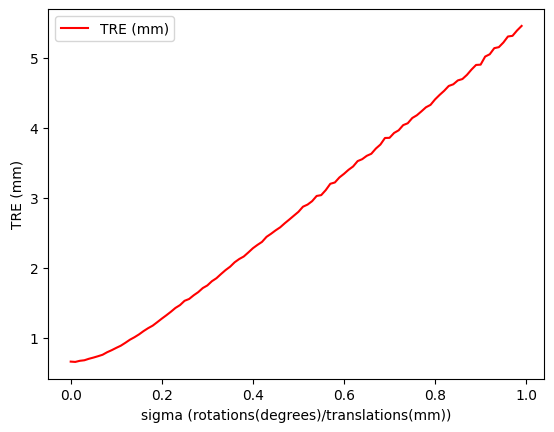

In [ ]:
x_values = []
y_values = []

for sigma_counter in range(0, 100, 1):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_at_patient[0:4,0:3], typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        # recompute transforms with noisy markers
        R, t, FRE = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_with_tip[0:4, 0:3])
        tmp_pointer_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        # transform tumour coords to MRI space using noisy transforms
        pointer_tip_in_mri_space = pointer_to_mri(tmp_pointer_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, origin)
        
        # calculate RMS
        euclid_dist = calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space)
        rms = rms + euclid_dist

    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    
    if sigma == 0.25:
        print(f'euclidean distance for sigma of {sigma} is {rms}')
        rms_25_registration = rms
    if sigma == 0.12:
        print(f'euclidean distance for sigma of {sigma} is {rms}')
        rms_12_registration = rms  
    if sigma == 0.15:
        print(f'euclidean distance for sigma of {sigma} is {rms}')
        rms_15_registration = rms      
        
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
        


# SUMMARY AND CONCLUSIONS OF POINTER BASED REGISTRATION 

### Tracking error

From experiment 1, Effect of tracking noise on pointer tip accuracy:

In [ ]:
print(f'Error from tracking noise for sigma 0.12 and pointer length 10mm: {rms_12_tracking[0]}mm') 
print(f'Error from tracking noise for sigma 0.15 and pointer length 10mm: {rms_15_tracking[0]}mm') 
print(f'Error from tracking noise for sigma 0.25 and pointer length 10mm: {rms_25_tracking[0]}mm') 


Error from tracking noise for sigma 0.12 and pointer length 10mm: 0.3185628113893953mm
Error from tracking noise for sigma 0.15 and pointer length 10mm: 0.39764605327485997mm
Error from tracking noise for sigma 0.25 and pointer length 10mm: 0.6627500198556152mm


Tracking error for different pointer lengths:

In [ ]:
print(f'sigma 0.12')
print(f'pointer length 10cm {pointer_lengths_12[0]}')
print(f'pointer length 15cm {pointer_lengths_12[1]}')
print(f'pointer length 20cm {pointer_lengths_12[2]}')

print(f'sigma 0.15')
print(f'pointer length 10cm {pointer_lengths_15[0]}')
print(f'pointer length 15cm {pointer_lengths_15[1]}')
print(f'pointer length 20cm {pointer_lengths_15[2]}')

print(f'sigma 0.25')
print(f'pointer length 10cm {pointer_lengths_25[0]}')
print(f'pointer length 15cm {pointer_lengths_25[1]}')
print(f'pointer length 20cm {pointer_lengths_25[2]}')

sigma 0.12
pointer length 10cm [0.3176935]
pointer length 15cm [0.39159599]
pointer length 20cm [0.47040248]
sigma 0.15
pointer length 10cm [0.39762355]
pointer length 15cm [0.49110128]
pointer length 20cm [0.58819692]
sigma 0.25
pointer length 10cm [0.65837841]
pointer length 15cm [0.81536202]
pointer length 20cm [0.97482493]


### SBR/PBR noise

This paper here: http://dx.doi.org/10.1118/1.4898103 suggests that errors in translation and rotation for a surface based registration might be of the order of 0.5-1.0 mm or degrees.

From the simulation:

In [ ]:
print(f'registration noise for sigma 0.12: {rms_12_registration[0]}')
print(f'registration noise for sigma 0.15: {rms_15_registration[0]}')
print(f'registration noise for sigma 0.25: {rms_25_registration[0]}')

registration noise for sigma 0.12: 0.931852680161658
registration noise for sigma 0.15: 1.0519526635044896
registration noise for sigma 0.25: 1.5314626239835762


### Distance errors

These were observed to be the same as the tracking errors and weren't increased or decresed.

### Total errors

And so the total errors with this simulation for pointer length 10cm would be:

In [ ]:
print(f'total sigma 0.12: {rms_12_tracking[0]+rms_12_registration[0]} mm')
print(f'total sigma 0.15: {rms_15_tracking[0]+rms_15_registration[0]} mm')
print(f'total sigma 0.25: {rms_25_tracking[0]+rms_25_registration[0]} mm')


total sigma 0.25: 2.1942126438391916 mm
total sigma 0.15: 1.4495987167793496 mm
total sigma 0.12: 1.2504154915510532 mm
